# MedMNIST Overwiew
Function below enable fast check how looks images and classes distribution in a specified dataset.

In [130]:
import torch
from medmnist import INFO
from typing import Literal
import matplotlib.pyplot as plt
from collections import Counter
from medmnist_dataset import DataFlag


def sum_up_dataset(data_flag:DataFlag,
                   img_size:Literal[28,64,128,224]=28, 
                   mode:Literal["train", "val", "test"]="train", 
                   download:bool=False,
                   only_images:bool=False
                  ):
    
    info = INFO[data_flag.value]
    DataClass = getattr(medmnist, info['python_class'])
    mmap_mode='r' if img_size==224 else None
    
    try:
        dataset = DataClass(split=mode, download=download, size=img_size, mmap_mode=mmap_mode)
    except Exception as e:
        print(e)

    def _class_distribution():
        labels = []
        
        for data in dataset:
            _, label = data
            labels.append(label.item())
        
        label_counts = Counter(labels)
        
        unique_labels = list(label_counts.keys())
        counts = list(label_counts.values())
        
        # Plot the distribution
        plt.figure(figsize=(10, 6))
        plt.bar(unique_labels, counts, color='skyblue')
        plt.xlabel('Class Labels')
        plt.ylabel('Count')
        plt.title('Class Distribution')
        plt.xticks(unique_labels)
        plt.show()

    def _print_description():
        print("DATASET DESCRIPTION:")
        print(info['description'])

    def _multilabel_distribution():
        num_labels=len(info['label'].keys())
        label_counts = np.zeros(num_labels)

        for data in dataset:
            _, labels = data
            label_counts += labels

        plt.figure(figsize=(12, 6))
        x = np.arange(num_labels)
        
        plt.bar(x, label_counts, color='skyblue')
        plt.xlabel('Label Index')
        plt.ylabel('Positive Count')
        plt.title('Distribution of Binary Labels')
        plt.xticks(x, [f'Label {i}' for i in x])
        plt.ylim(0, np.max(label_counts) + 10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)    
        plt.show()
            
    _print_description()
    if info['task']=='multi-class' or info['task']=='binary-class':
        _class_distribution()
    elif info['task']=='multi-label, binary-class':
        _multilabel_distribution()
    return dataset


def visualize(dataset):
    info = dataset.info
    img_size = dataset.size
    if img_size == 28:
        length = 10
    elif img_size == 64:
        length = 5
    elif img_size == 128:
        length = 2
    elif img_size == 224:
        length = 2
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.montage(length=length), cmap='gray' if info['n_channels']==1 else 'viridis')
    plt.title('Examples')
    plt.show()

## Class distribution

DATASET DESCRIPTION:
The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.


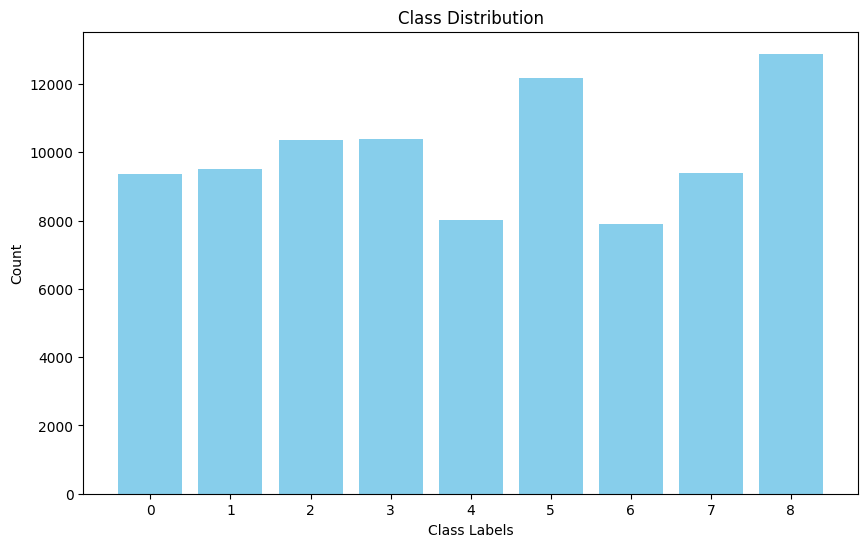

In [131]:
dataset = sum_up_dataset(data_flag=DataFlag.PATHMNIST, img_size=224, mode="train", download=False)

## Examples visualization

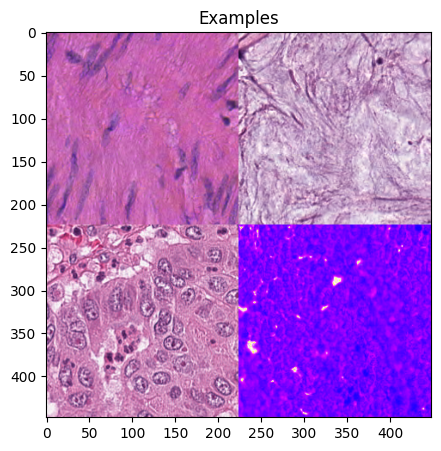

In [134]:
visualize(dataset)

In [10]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|███████████████████████████████████████████████████████████| 12629854322/12629854322 [08:30<00:00, 24759332.72it/s]


In [11]:
batch = next(iter(train_loader))

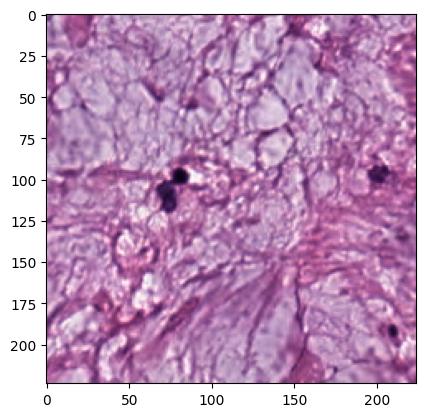

In [16]:
plt.imshow(torch.movedim(batch[0][0], 0,2))

In [20]:
batch[1].shape

torch.Size([128, 1])

In [42]:
data_flag = 'tissuemnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [43]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/jbinda/.medmnist/tissuemnist.npz
Using downloaded and verified file: /home/jbinda/.medmnist/tissuemnist.npz


In [44]:
info

{'python_class': 'TissueMNIST',
 'description': 'We use the BBBC051, available from the Broad Bioimage Benchmark Collection. The dataset contains 236,386 human kidney cortex cells, segmented from 3 reference tissue specimens and organized into 8 categories. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. Each gray-scale image is 32×32×7 pixels, where 7 denotes 7 slices. We take maximum values across the slices and resize them into 28×28 gray-scale images.',
 'url': 'https://zenodo.org/records/10519652/files/tissuemnist.npz?download=1',
 'MD5': 'ebe78ee8b05294063de985d821c1c34b',
 'url_64': 'https://zenodo.org/records/10519652/files/tissuemnist_64.npz?download=1',
 'MD5_64': '123ece2eba09d0aa5d698fda57103344',
 'url_128': 'https://zenodo.org/records/10519652/files/tissuemnist_128.npz?download=1',
 'MD5_128': '61b955355d7425a89687b06cca3ce0c2',
 'url_224': 'https://zenodo.org/records/10519652/files/tissuemnist_224.npz?download=1',
 'MD5_224': 'b0

In [45]:
imgs = []
for i in range(len(train_dataset)):
    imgs.append(train_dataset[i][0])
imgs=torch.stack(imgs)

In [46]:
imgs.shape

torch.Size([165466, 1, 28, 28])

In [47]:
mean=torch.mean(imgs, dim=(0,2,3))
mean.shape

torch.Size([1])

In [83]:
batch = next(iter(train_loader))

In [85]:
batch[0].shape

torch.Size([128, 1, 28, 28])

In [104]:
pics = batch[0][21][0]

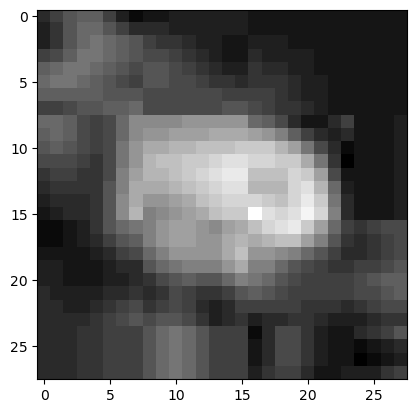

In [105]:
plt.imshow(pics, cmap="gray")

In [48]:
data_flag = "nodulemnist3d"
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [49]:
info

{'python_class': 'NoduleMNIST3D',
 'description': 'The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/nodulemnist3d.npz?download=1',
 'MD5': '8755a7e9e05a4d9ce80a24c3e7a256f3',
 'url_64': 'https://zenodo.org/records/10519652/files/nodulemnist3d_64.npz?download=1',
 'MD5_64': 'c47c5b7d457bf6332200d2ea6d64ecd8',
 'task': 'binary-class',
 'label': {'0': 'benign', '1': 'malignant'},
 'n_channels': 1,
 'n_samples': {

In [50]:
# load the data
train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/jbinda/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/jbinda/.medmnist/nodulemnist3d.npz


In [52]:
imgs=[]
for i in range(len(train_dataset)):
    imgs.append(torch.tensor(train_dataset[i][0]))
imgs=torch.stack(imgs)
imgs.shape

torch.Size([1158, 1, 28, 28, 28])

In [57]:
batch = next(iter(train_loader))

In [77]:
crop = batch[0][6][0]

In [78]:
crop.shape

torch.Size([28, 28, 28])

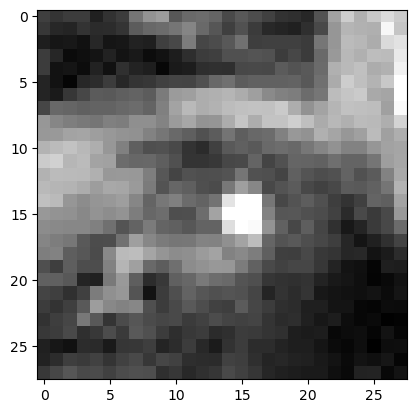

In [79]:
plt.imshow(crop[14,:,:], cmap='gray')